In [19]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from bs4 import BeautifulSoup
import requests
import re
import json
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [20]:
!pip install selenium
from selenium import webdriver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred.ravel()) / np.mean(y_true))) * 100

In [22]:
def plotModelResults(model, X_train, y_train, X_test, y_test, plot_intervals=False):
    """
        Plots modelled vs fact values, prediction intervals

    """
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv,
                             scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

    error = MAD_mean_ratio(y_test, prediction)
    plt.title("Test data MAD_mean_ratio error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [23]:
def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [24]:
def extract(url):

    """regular expression for a string which starts with "http://www.risk.net/" or https://www.risk.net/, 
    followed immediately by ("quantitative-finance/" followed by some numbers) or (some numbers)"""
    # regex = r"^https?://www\.risk\.net/((quantitative-finance|risk-quantum)/\d+/quant-guide-|\d+)"
    year_regex = r'\b\d{4}\b'
    prev_year_regex = r'"https?://www\.risk\.net/([^"]*?)/quant-finance-masters-guide-(.*?)"'
    table_url_base = "https://www.risk.net/quant-masters-{0}"
    # table_url_regex = r'"https://infogram.com/quant-(.*?)"'

    prev_year_url = None
    res_df = pd.DataFrame()

    while True:
        if prev_year_url is not None:
            url = prev_year_url
            prev_year_url = None

        html = requests.get(url).text
        # soup = BeautifulSoup(html, 'html5lib')

        year = int(re.search(year_regex, url).group(0))
        print("year: {0}".format(year))

        search = re.search(prev_year_regex, html)
        if search is not None:
            prev_urls = [x.group(0).replace('"', '') for x in re.finditer(prev_year_regex, html)]
            prev_urls = [x for x in prev_urls if int(x[-4:]) < year]
            if len(prev_urls) > 0:
                prev_year_url = prev_urls[0]

        print('\tfetching data ...')
        yr_rankings_df = None
        if year >= 2022:
            table_url = table_url_base.format(year)
            table_html = requests.get(table_url).text
            table_soup = BeautifulSoup(table_html, 'html5lib')
            table_div = table_soup.find_all('div', {"class": "table-content"})[0]
            yr_rankings_df = pd.read_html(str(table_div('table')[0]).replace('style="display: none;"', ''))[0]
        else:
            options = webdriver.ChromeOptions()
            options.add_argument("--headless=new")
            path = '/opt/homebrew/bin/chromedriver'
            browser = webdriver.Chrome(path, options=options)
            browser.get(url)
            soup = BeautifulSoup(browser.page_source, "lxml")
            browser.close()

            iframe_tags = soup.find_all('iframe')
            iframe_url = None
            for iframe in iframe_tags:
                iframe_url = iframe['src'] if iframe.has_attr('src') else None
                if (iframe_url is not None) and ('infogram' in iframe_url):
                    break

            if iframe_url is not None:
                iframe_html = requests.get(iframe_url).text
                iframe_soup = BeautifulSoup(iframe_html, 'html5lib')
                script_tags = iframe_soup.find_all('script')
                for script_tag in script_tags:
                    if script_tag.string is not None:
                        search = re.search('{.*}', script_tag.string)
                        if search is not None:
                            try:
                                data_json = json.loads(search.group(0))
                            except ValueError as e:
                                continue

                            if 'elements' in data_json.keys() and 'data' in data_json['elements'][1].keys():
                                data_list = json.loads(re.search('{.*}', script_tag.string).group(0))['elements'][1]['data'][0]
                                # print(data_list)
                                yr_rankings_df = pd.DataFrame(data_list)
                                yr_rankings_df.columns = yr_rankings_df.iloc[0]
                                yr_rankings_df = yr_rankings_df.iloc[1:]

        print('\tcleaning data ...')
        """Data Cleaning"""
        if yr_rankings_df is not None:
            rename_dict = {'University/institution': 'University',
                           'Programme title': 'Programme',
                           'No. of students': 'Class size',
                           'Accept. rate': 'Acceptance rate',
                           'Salary': 'Salary ($)',
                           'Salary (US$, adjusted)': 'Salary ($)',
                           'Empl. rate': 'Employment rate',
                           'Employ. rate in finance': 'Employment rate',
                           'Industry-affiliated lecturers': 'Industry lecturers',
                           'Lecturers’ citations': 'Lecturer citations',
                           'Lecturers citations': 'Lecturer citations',
                           'Total citations, top five lecturers': 'Lecturer citations',
                           'Students accepting offers': 'Students accepting'}
            yr_rankings_df = yr_rankings_df.rename(columns=rename_dict)
            if isinstance(yr_rankings_df['University'].iloc[0], dict):
                yr_rankings_df['Link'] = yr_rankings_df['University'].apply(lambda x: x['href'])
                yr_rankings_df['University'] = yr_rankings_df['University'].apply(lambda x: x['value'])

            yr_rankings_df['Year'] = year
            yr_rankings_df = yr_rankings_df.set_index(['Year', 'University'])

            yr_rankings_df = yr_rankings_df.replace(['n/a', 'N/A', '', ' ', u'\xa0'], np.NaN)

            """Special characters"""
            if 'Lecturer citations' in yr_rankings_df.columns and type(yr_rankings_df['Lecturer citations'].iloc[0]) == str:
                yr_rankings_df['Lecturer citations'] = yr_rankings_df['Lecturer citations'].str.replace(',', '')
            yr_rankings_df['Salary ($)'] = yr_rankings_df['Salary ($)'].str.replace('$', '')
            yr_rankings_df['Salary ($)'] = yr_rankings_df['Salary ($)'].str.replace(',', '')

            if yr_rankings_df['Salary ($)'].str.contains('–').any():
                "take average of range"
                salary = pd.DataFrame(yr_rankings_df['Salary ($)'].dropna().str.split('–').apply(lambda x: np.mean(list(map(int, x)))), columns=['Salary ($)'])
                yr_rankings_df = yr_rankings_df.drop(columns=['Salary ($)'])
                yr_rankings_df = yr_rankings_df.merge(salary, how='left', left_index=True, right_index=True)

            perc_cols = ['Acceptance rate', 'Students accepting', 'Industry lecturers', 'Employment rate']
            int_cols = ['Class size', 'Lecturer citations', 'Salary ($)', 'Rank']
            float_cols = ['Students/lecturers']

            fill_na_cols = ['Industry lecturers', 'Lecturer citations']
            fill_na_cols = list(set(fill_na_cols).intersection(set(yr_rankings_df.columns)))
            if len(fill_na_cols) > 0:
                yr_rankings_df[fill_na_cols] = yr_rankings_df[fill_na_cols].fillna(0.0)
            drop_na_cols = list(set(perc_cols+int_cols+float_cols).intersection(set(yr_rankings_df.columns)) - set(fill_na_cols))
            yr_rankings_df = yr_rankings_df.dropna(how='any', axis=0, subset=drop_na_cols)

            for col in int_cols:
                if col in yr_rankings_df.columns:
                    yr_rankings_df[col] = yr_rankings_df[col].astype(int)

            for col in float_cols:
                if col in yr_rankings_df.columns:
                    try:
                        yr_rankings_df[col] = yr_rankings_df[col].astype(float)
                    except:
                        pass

            for col in perc_cols:
                if col in yr_rankings_df.columns:
                    try:
                        yr_rankings_df[col] = yr_rankings_df[col].str.replace('%', '').astype(float)/100
                    except:
                        pass

            res_df = pd.concat([res_df, yr_rankings_df], axis=0)

        if prev_year_url is None:
            break

    return res_df

In [50]:
def analyze_university(data, uni_name):
    uni_df = data[data.index.get_level_values(1).str.contains(uni_name)].droplevel(1)
    uni_df = uni_df.sort_index()
    rank_series = uni_df['Rank']

    "2 - rank time series plot"
    rank_series.plot(xticks=rank_series.index)

    "2 - relationship between features and ranks"
    uni_df = uni_df.dropna(axis=1)
    features = uni_df.columns.tolist()
    features.remove('Rank')
    feature_df = uni_df[features]
    corr_data = feature_df.apply(lambda col: pearsonr(col, rank_series), axis=0)
    corr_df = corr_data.T.reset_index()
    corr_df.columns = ['Feature', 'Pearson Corr', 'Pearson P-Value']

    corr_data = feature_df.apply(lambda col: spearmanr(col, rank_series), axis=0)
    spearman_df = corr_data.T.reset_index()
    spearman_df.columns = ['Feature', 'Spearman Corr', 'Spearman P-Value']
    corr_df = corr_df.merge(spearman_df, how='left', on='Feature')
    print("Correlation of ranks with features:\n", corr_df)

    # corr_plot = sns.barplot(x=corr_df['Feature'], y=corr_df['Corr'], data=corr_df, orient='v', width=0.5)
    # for item in corr_plot.get_xticklabels():
    #     item.set_rotation(45)
    # corr_plot.set_ylim(-1, 1)

    "3 - factor changes over the years"

    scaled_feature_df = feature_df.apply(lambda col: (col - col.mean()) / col.std(), axis=0).round(2)  #standardization
    scaled_feature_df.plot(xticks=scaled_feature_df.index)


    change_df = feature_df - feature_df.shift(1)
    change_df = change_df.dropna(axis=0).round(2)
    # scaled_feature_df = change_df.apply(lambda col: (col - col.mean()) / col.std(), axis=0).round(2)  #standardization
    scaled_feature_df = change_df.apply(lambda col: (col) / (col.max() - col.min()), axis=0).round(2)  # kind of min-max scalar but not exactly
    

    x = np.arange(len(scaled_feature_df.index))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for feature in features:
        offset = width * multiplier
        rects = ax.bar(x + offset, scaled_feature_df[feature], width, label=feature)
        ax.bar_label(rects, padding=5)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% Change in feature')
    ax.set_title('Factor Changes over time')
    ax.set_xticks(x + width, scaled_feature_df.index)
    ax.legend(loc='upper left')
    ax.set_ylim(-2, 2)
    plt.show()

In [26]:
def model_analysis(model, X_train, y_train, X_test, y_test, plot_coef):

    predictions_train = model.predict(X_train)
    print("Train R2 score", metrics.r2_score(y_train, predictions_train))
    print("Train MAE score", metrics.mean_absolute_error(y_train, predictions_train))
    train_error = MAD_mean_ratio(y_train, predictions_train)
    print("Train data MAD_mean_ratio error {0:.2f}%".format(train_error))
    rho, pval = spearmanr(y_train, predictions_train)
    print('Train data spearman rho = {}, p-val={}'.format(rho, pval))

    predictions_test = model.predict(X_test)
    print("Test R2 score", metrics.r2_score(y_test, predictions_test))
    print("Test MAE score", metrics.mean_absolute_error(y_test, predictions_test))
    test_error = MAD_mean_ratio(y_test, predictions_test)
    print("Test data MAD_mean_ratio error {0:.2f}%".format(test_error))
    rho, pval = spearmanr(y_test, predictions_test)
    print('Test data spearman rho = {}, p-val={}'.format(rho, pval))

    plotModelResults(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

    if plot_coef:
        best_model = model.best_estimator_[1]
        plotCoefficients(best_model, X_train)

In [27]:
def linear_regression_model(data):
    df = data.sort_index()
    rank_series = df['Rank']
    df = df.dropna(axis=1)
    features = df.columns.tolist()
    features.remove('Rank')
    feature_df = df[features]

    X_train, X_test, y_train, y_test = train_test_split(feature_df, rank_series, test_size=0.2, random_state=4)

    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('linear', LinearRegression())])

    param_grid = [{'linear__fit_intercept': [0, 1]}]
    grid_search_object = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', return_train_score=True, n_jobs=-1, refit=True)
    best_lr = grid_search_object.fit(X_train, y_train).best_estimator_
    best_mean_score = grid_search_object.best_score_
    print("best mean R2 score", best_mean_score)
    best_parameters = grid_search_object.best_params_
    print(best_parameters)

    print("intercept: ", best_lr[1].intercept_)
    print("coefficient: ", best_lr[1].coef_)

    model_analysis(grid_search_object, X_train, y_train, X_test, y_test, plot_coef=True)

    return grid_search_object

In [28]:
def ridge_regression_model(data):
    df = data.sort_index()
    rank_series = df['Rank']
    df = df.dropna(axis=1)
    features = df.columns.tolist()
    features.remove('Rank')
    feature_df = df[features]

    X_train, X_test, y_train, y_test = train_test_split(feature_df, rank_series, test_size=0.2, random_state=4)

    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('ridge', Ridge())])

    param_grid = [{'ridge__alpha':[1000,500,100,50,10,5,1,.5,.1]}]
    grid_search_object = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', return_train_score=True, n_jobs=-1, refit=True)
    best_lr = grid_search_object.fit(X_train, y_train).best_estimator_
    best_mean_score = grid_search_object.best_score_
    print("best mean R2 score", best_mean_score)
    best_parameters = grid_search_object.best_params_
    print(best_parameters)

    print("intercept: ", best_lr[1].intercept_)
    print("coefficient: ", best_lr[1].coef_)

    model_analysis(grid_search_object, X_train, y_train, X_test, y_test, plot_coef=True)

    return grid_search_object

In [29]:
def neural_network_model(data):
    df = data.sort_index()
    rank_series = df['Rank']
    df = df.dropna(axis=1)
    features = df.columns.tolist()
    features.remove('Rank')
    feature_df = df[features]

    scaled_features = StandardScaler().fit_transform(feature_df)
    X_train, X_test, y_train, y_test = train_test_split(scaled_features, rank_series, test_size=0.2, random_state=4)

    # define the keras model
    model = Sequential()
    model.add(Dense(40, input_shape=(len(features),), activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation=None))
    # compile the keras model
    model.compile(loss='MeanAbsoluteError', optimizer='adam', metrics=['RootMeanSquaredError'])
    # fit the keras model on the dataset
    model.fit(X_train, y_train, epochs=800, batch_size=200)

    model_analysis(model, X_train, y_train, X_test, y_test, plot_coef=False)

    return model

In [30]:
def random_forest_model(data):
    df = data.sort_index()
    rank_series = df['Rank']
    df = df.dropna(axis=1)
    features = df.columns.tolist()
    features.remove('Rank')
    feature_df = df[features]

    scaled_features = StandardScaler().fit_transform(feature_df)
    X_train, X_test, y_train, y_test = train_test_split(scaled_features, rank_series, test_size=0.2, random_state=4)

    model = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42, max_depth=2)
    model.fit(X_train, y_train)

    # Predicting the Test set results
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    # Making the Confusion Matrix
    print(pd.crosstab(y_train, pred_train, rownames=['Actual Rank'], colnames=['Predicted Rank']))
    print(pd.crosstab(y_test, pred_test, rownames=['Actual Rank'], colnames=['Predicted Rank']))
    plotModelResults(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    train_f1_score = metrics.f1_score(y_train, pred_train, average='macro')
    test_f1_score = metrics.f1_score(y_test, pred_test, average='macro')
    print('Train F1 score: {:.2f}'.format(train_f1_score))
    print('Test F1 score: {:.2f}'.format(test_f1_score))

    print('Train Results')
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_train, pred_train)
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))

    print('Test Results')
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, pred_test)
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))

    return model


In [31]:
def random_forest_model2(data):
    df = data.sort_index()
    rank_series = df['Rank']
    df = df.dropna(axis=1)
    features = df.columns.tolist()
    features.remove('Rank')
    feature_df = df[features]

    X_train, X_test, y_train, y_test = train_test_split(feature_df, rank_series, test_size=0.2, random_state=4)

    rf = RandomForestClassifier(criterion = 'gini', random_state = 42)
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('rf', rf)])

    param_grid = [{'rf__max_depth':[2,4,6,8,10,12,14,16,18,20], 'rf__min_samples_split': [1,2,3,4,5], 'rf__n_estimators': [10,20,40,60,100,200]}]
    grid_search_object = GridSearchCV(pipeline, param_grid, cv=4, scoring='accuracy', return_train_score=True, n_jobs=-1, refit=True)
    best_lr = grid_search_object.fit(X_train, y_train).best_estimator_
    best_mean_score = grid_search_object.best_score_
    print("best mean accuracy", best_mean_score)
    best_parameters = grid_search_object.best_params_
    print(best_parameters)

    # Predicting the Test set results
    pred_train = grid_search_object.predict(X_train)
    pred_test = grid_search_object.predict(X_test)
    # Making the Confusion Matrix
    print(pd.crosstab(y_train, pred_train, rownames=['Actual Rank'], colnames=['Predicted Rank']))
    print(pd.crosstab(y_test, pred_test, rownames=['Actual Rank'], colnames=['Predicted Rank']))
    plotModelResults(grid_search_object, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    train_f1_score = metrics.f1_score(y_train, pred_train, average='macro')
    test_f1_score = metrics.f1_score(y_test, pred_test, average='macro')
    print('Train F1 score: {:.2f}'.format(train_f1_score))
    print('Test F1 score: {:.2f}'.format(test_f1_score))

    print('Train Results')
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_train, pred_train)
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))

    print('Test Results')
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, pred_test)
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))

    return grid_search_object

In [32]:
def predict_ranking(model, feature_dict):
    rank = model.predict()
    return rank

In [55]:
def main(scrape, path, uni):
    print('start')

    if scrape:
        start_time = time.time()
        url = "https://www.risk.net/quantitative-finance/7905251/quant-finance-masters-guide-2022"
        data = extract(url=url)
        print("--- {:.2f} seconds ---".format(time.time() - start_time))
        with open(path, 'wb') as output_file:
            pickle.dump(data, output_file)
    else:
        with open(path, 'rb') as output_file:
            data = pickle.load(output_file)

    analyze_university(data, uni)
    lr_model = linear_regression_model(data)
    rr_model = ridge_regression_model(data)
    nn_model = neural_network_model(data)
    rf_model = random_forest_model2(data)

    # feature_dict = {}
    # rank = predict_ranking(lr_model, feature_dict)

    print('end')

In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


start
best mean accuracy 0.1323529411764706
{'rf__max_depth': 10, 'rf__min_samples_split': 4, 'rf__n_estimators': 10}
Predicted Rank  1   2   3   4   5   6   7   8   9   10  ...  15  16  18  19  \
Actual Rank                                             ...                   
1                4   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
2                0   2   0   0   0   0   0   0   0   0  ...   0   0   0   0   
3                0   0   3   0   0   0   0   0   0   0  ...   0   0   0   0   
4                0   0   0   4   0   0   0   0   0   0  ...   0   0   0   0   
5                0   0   0   0   3   0   0   0   0   0  ...   0   0   0   0   
6                0   0   0   0   0   3   0   0   0   0  ...   0   0   0   0   
7                0   0   0   0   0   0   3   0   0   0  ...   0   0   0   0   
8                0   1   0   0   0   0   0   3   0   0  ...   0   0   0   0   
9                0   0   0   0   0   0   0   0   1   1  ...   0   0   0   0   
10           

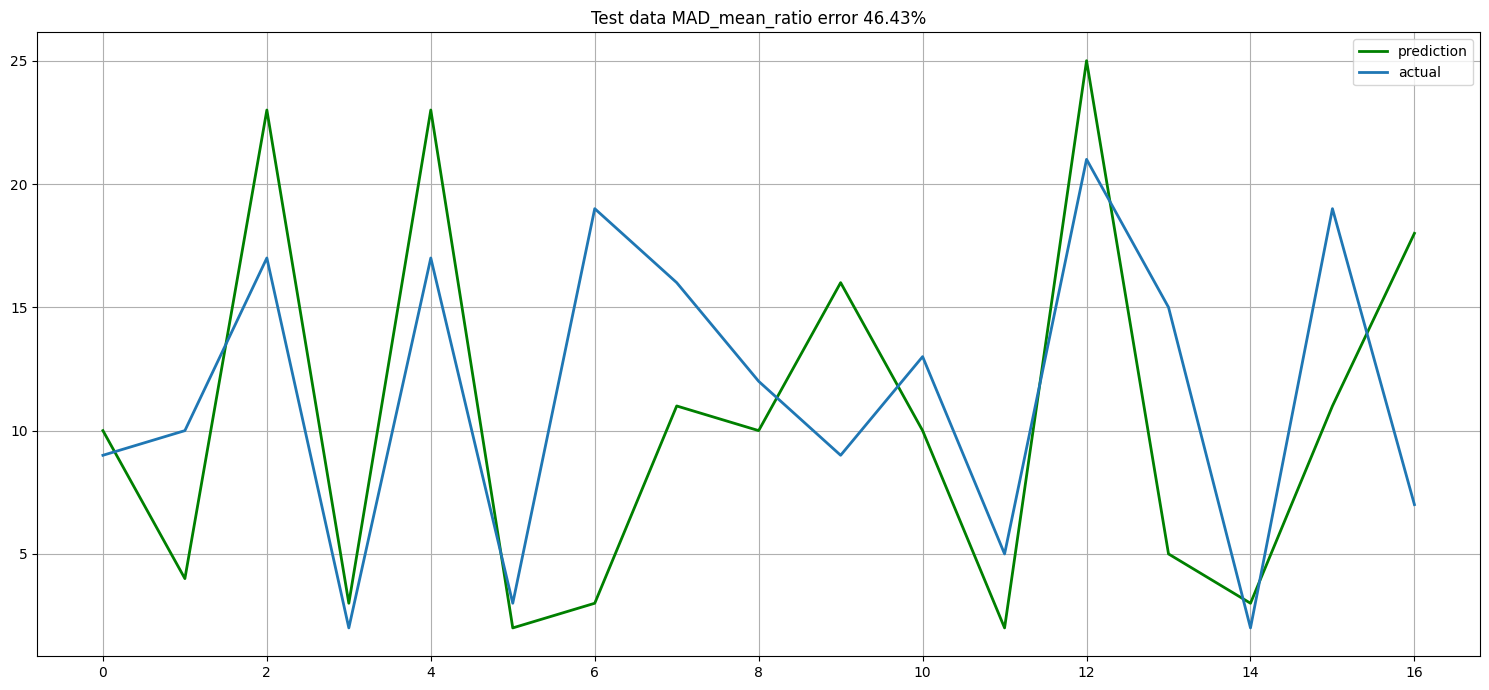

In [56]:
main(scrape=True, path='/content/drive/MyDrive/Colab Notebooks/combined_data.pkl', uni='Tandon')